In [1]:
from pickle import load
import os
import torch
from utils import SimplexEnvironment

MDP = load(open(os.path.join("data", "mdps", "small" ,"small_mdp.bin"), 'rb'))
t = torch.from_numpy(MDP.get_transitions()).to(torch.float32)

100%|██████████| 10/10 [00:00<00:00, 624.67it/s]


In [2]:
from utils import Net
import torch.optim as optim
import torch.nn as nn

criterion = nn.NLLLoss()
optimizer = optim.Adam
optim_params = {"lr":0.001}
model = Net(MDP.S, MDP.A, MDP.d, criterion, optimizer,  optim_params, real_transitions=t)


In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [4]:
model.to(device)

In [5]:
import numpy as np
def reward(s_prev, a, s_next):
    return np.log(s_prev + 1) + np.log(a + 1) + np.log(s_next + 1)


In [6]:
def sherman_morrison(inverse, v):
    """
    Calculates the inverse of A + (v * v^t) using the sherman-morrison formula
    # Parameters:
    inverse: Previous inverse of size (n, n)
    v: Column vector of size (n, 1)
    """
    # print(inverse.shape, v.shape)
    w = inverse @ v

    return inverse - (w @ w.T)/(1 + np.dot(v.T, w))

def calc_inverse_cov(inverse, vectors: list[np.ndarray]):
    S = inverse.copy()
    for v in vectors:
        S = sherman_morrison(S, v)
    
    return S


In [7]:
n = 64
Jmax = 2000

In [8]:
%%time
from tqdm import tqdm
import random
from utils import ListDataset


data_set = []
losses = []

s_prev = 0
inv_covariance = np.eye(model.d)
did_converge = []

with tqdm(range(Jmax)) as tepoch:
    for i in tepoch:

        # Take n Samples
        a = random.randint(0, (model.actions - 1))
        new_data = [(s_prev, a, MDP.next_step_state(s_prev, a))  for _ in range(n)]
        batch_data = random.choices(data_set, k=n) if i > 0 else []
        batch_data.extend(new_data) # Size 2n

        batch_size = len(batch_data) // 2

     

        # Get approximation of MLE
        running_loss = model.backward(ListDataset(batch_data, batch_size= batch_size))

        # Save metrics
        tepoch.set_postfix(loss=f'{running_loss / 10:.3f}')
        losses.append(running_loss)

        # Add all new data to old data
        data_set.extend(new_data) 

        # Planner for the next state
        with torch.no_grad():
            # Get vector for covariance matrix
            s1 = torch.tensor([new_data[i][0] for i in range(n // 2)])
            a1 = torch.tensor([new_data[i][1] for i in range(n // 2)])

            v = model.phi(s1, a1).detach().to("cpu").numpy().reshape(-1, model.d, 1)
            inv_covariance = calc_inverse_cov(inv_covariance, v)
            planner, V, policy, converge = model.rep_ucb_planner(reward, inv_covariance)
            did_converge.append(converge)
            a_next = planner(s_prev)
            s_prev = MDP.next_step_state(s_prev, a_next)

100%|██████████| 2000/2000 [04:57<00:00,  6.73it/s, loss=0.436]

CPU times: total: 26min 16s
Wall time: 4min 57s


In [10]:
# print convergences

np.sum(np.array(did_converge, dtype=np.int32))

2000

In [9]:
from pickle import dump 

dump([model, losses], open('./data/models/repucb_lgbatch_jmax2000.bin', 'wb'))

Text(0, 0.5, 'NLLLoss')

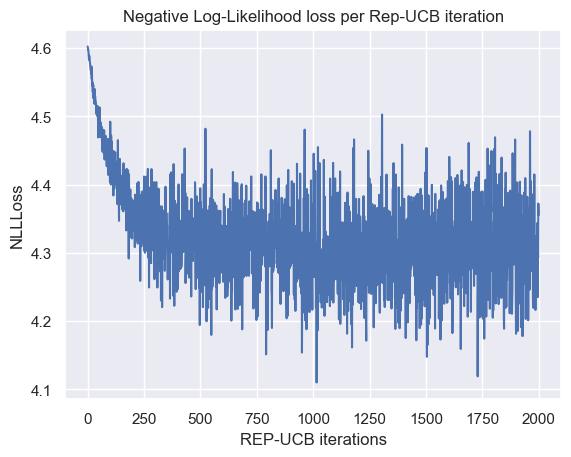

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme()
plt.plot(losses)
plt.title("Negative Log-Likelihood loss per Rep-UCB iteration")
plt.xlabel("REP-UCB iterations")
plt.ylabel("NLLLoss")
plt.savefig("./images/small_mdp_repucb_lgbatch_lgjmax_jmax2000_losses.pdf",format="pdf", bbox_inches="tight")

Text(0, 0.5, '$\\sum_{a \\in \\mathcal{A}}||X_a - M_a||_{fb}$')

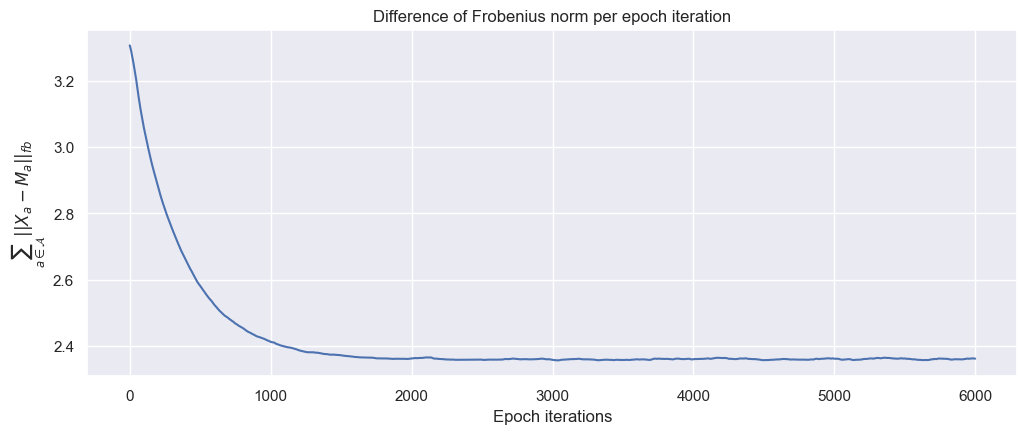

In [12]:
plt.figure(figsize=(12, 4.5))
plt.plot(model.frob_diff)
plt.title("Difference of Frobenius norm per epoch iteration")
plt.xlabel("Epoch iterations")
plt.ylabel("$\sum_{a \in \mathcal{A}}||X_a - M_a||_{fb}$")
# plt.savefig("./images/small_mdp_repucb_lgbatch_lgjmax_jmax2000_fb_diff.pdf",format="pdf", bbox_inches="tight")

Optimal Value Function and Policy

In [16]:
%%time
from utils import PolicyIteration

def next_state_prob(s, a):
            with torch.no_grad():
                return model.forward(torch.from_numpy(s.ravel()).to(model.device).long(), 
                                    torch.from_numpy(a.ravel()).to(model.device).long()).to("cpu").numpy()

pol_iter = PolicyIteration(model.states , model.actions, next_state_prob , reward)

v, pol, _ = pol_iter.run()



  0%|          | 1/2000 [00:00<00:11, 169.67it/s]

CPU times: total: 15.6 ms
Wall time: 33 ms


In [19]:
from pickle import load

v_true, pol_true = load(open(os.path.join("data", "mdps", "small" ,"small_mdp_optimals.bin"), 'rb'))

np.mean(np.abs(v_true - v_true))



0.03413153892984826